# SAMPLE Data Exploration Analysis

## 0. IMPORTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.decomposition import FastICA, PCA

# import scipy.constants as const
# import scipy
# from scipy.io import wavfile
# from scipy import signal

from IPython.core.display import HTML, display
from IPython.display import display, Audio

import sys
import base64
import struct  
import librosa
import librosa.display

## 1. GET THE SAMPLE DATA 

In [3]:
x, fs = librosa.load("data/ldc93s1/LDC93S1.wav", sr=16000)

In [4]:
print("Shape and type of the Audio data x:", x.shape, type(x))

tot_secs_len = len(x)/fs
tot_mins_len = tot_secs_len/60

print("\nSeconds:", tot_secs_len, "\nMins:", tot_mins_len)

x

('Shape and type of the Audio data x:', (46797,), <type 'numpy.ndarray'>)
('\nSeconds:', 2, '\nMins:', 0)


array([  3.05175781e-05,  -3.05175781e-05,   6.10351562e-05, ...,
        -3.05175781e-05,  -1.52587891e-04,  -2.44140625e-04], dtype=float32)

## 2. SUBSET

Let's make the data into a smaller sample so it's easier to work with. Let's work with the first 15 seconds of data only.

## 3. TEST PLAY

To check everything is as it should be, we can play the file with the built in Juypter Audio player.

" She had your dark suit in greasy wash water all year. "

In [5]:
# load a NumPy array
Audio(x, rate=fs)

## 4. PLOTS

What does this look like as a standard plot or as a spectrogram?

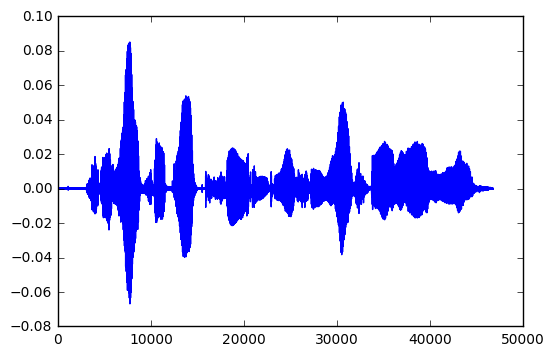

In [6]:
#Standard Plot
plt.plot(x)
plt.show()

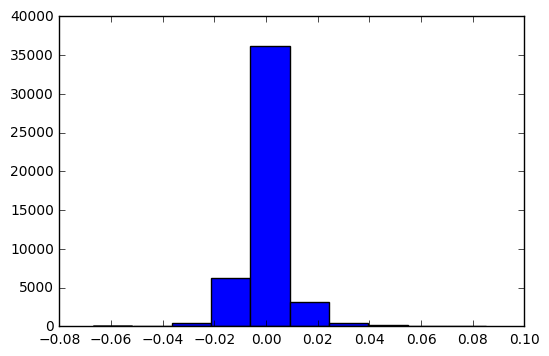

('Sample Mean:', -8.1457156e-06)
('Sample Std:', 0.0084797265)


In [7]:
#Histogram
plt.hist(x)
plt.show()

#What are the parameters our sample distribution?
print("Sample Mean:", x.mean())
print("Sample Std:", x.std())

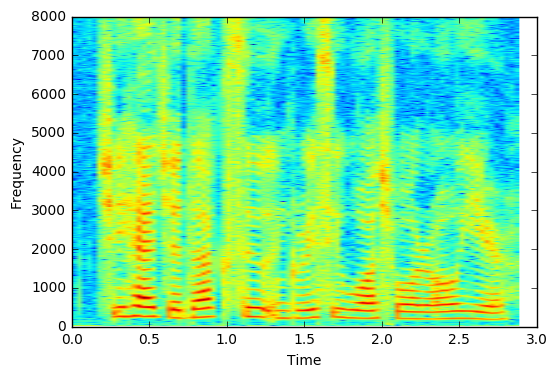

In [8]:
SS, freqs, bins, im = plt.specgram(x, NFFT=1024, Fs=fs, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

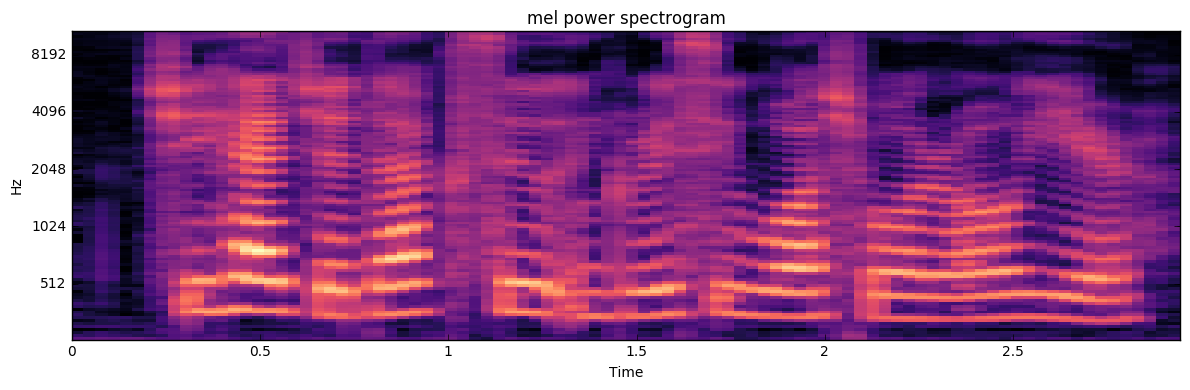

In [9]:
#What about a MEL SPECOGRAM?

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(x, sr=fs, n_mels=128)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=fs, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
#plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()
plt.show()

### What's the difference between a Spectogram and a Mel-Power Spectogram?

A typical spectrogram uses a linear frequency scaling, so each frequency bin is spaced the equal number of Hertz apart. The mel-frequency scale on the other hand, is a quasi-logarithmic spacing roughly resembling the resolution of the human auditory system.

## 5. TRANSFORM

Convert audio into MFCC (for DS1)



In [10]:
# Let's make and display a mfcc
mfcc = librosa.feature.mfcc(x, sr=fs, n_mfcc=26)

print(mfcc)
print(mfcc.shape)

[[ -7.10851527e+02  -7.00449206e+02  -6.69482837e+02 ...,  -5.54455997e+02
   -5.87665631e+02  -6.26060874e+02]
 [  3.39975646e+01   4.15417412e+01   6.26155418e+01 ...,   5.90154969e+01
    4.25220255e+01   4.31393198e+01]
 [  7.95981059e+00   4.90073931e+00  -5.73262763e+00 ...,  -6.72576945e+01
   -6.42231152e+01  -5.07805881e+01]
 ..., 
 [  5.43565871e+00   3.29820687e+00  -2.60467072e-01 ...,  -4.27004540e+00
    7.21372715e+00   9.63581343e+00]
 [  3.74167668e+00   3.81097755e+00   2.53648998e+00 ...,  -4.75553064e+00
    2.57592875e+00   2.43274625e+00]
 [  4.64921916e+00   3.18906455e+00   2.60010602e+00 ...,   4.73735015e+00
    6.94270050e+00   1.76299818e+00]]
(26, 92)


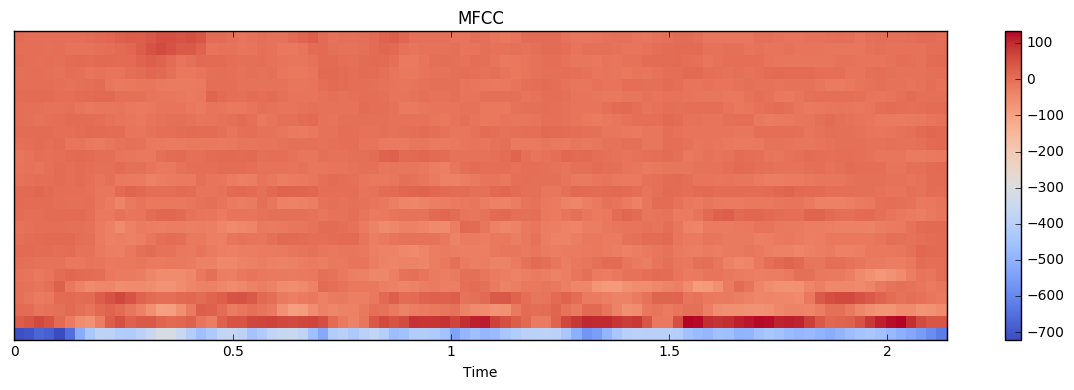

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

## 6. KERAS

We can load this mfcc data into a DS1 NN

In [53]:
# imports
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Activation, Bidirectional, Reshape, Lambda, Input
from keras.optimizers import SGD, adam

from keras.layers.merge import add, concatenate



26

In [40]:
# Define CTC loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



## 7. MODEL

Let's build the model

In [50]:
# Network Params
fc_size = 2048
rnn_size = 512
rnn_steps = 16
act = 'relu'

# This returns shape of audio mfcc which is 26x92
input_shape = mfcc.shape # 26 x 92

# Creates a tensor there are always 26 MFCC's however we don't know how many secs
inputs = Input(shape=(input_shape[0],))

# First 3 FC layers
x = Dense(fc_size, name='fc1', activation='relu')(inputs)
x = Dense(fc_size, name='fc2', activation='relu')(x)
x = Dense(fc_size, name='fc3', activation='relu')(x)

# Layer 4 BiDirectional RNN
to_rnn_dims = (fc_size/rnn_steps, rnn_steps)
x = Reshape(target_shape=to_rnn_dims, name='reshape')(x)
# x = Bidirectional(SimpleRNN(rnn_size, return_sequences=True, go_backwards=False, name='rnn_f'))(x)
# x = Bidirectional(SimpleRNN(rnn_size, return_sequences=True, go_backwards=True, name='rnn_b'))(x)

rnn_1f = SimpleRNN(rnn_size, return_sequences=True, go_backwards=False, kernel_initializer='he_normal', name='rnn_f')(x)
rnn_1b = SimpleRNN(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='rnn_b')(x)
rnn_merged = add([rnn_1f, rnn_1b])
x = Activation('relu', name='birelu')(rnn_merged)

# Layer 5 FC Layer
x = Dense(fc_size, name='fc5', activation='relu')(x)

# Layer 6 Output via softmax
y_pred = Activation('softmax', name='softmax')(x)


In [ ]:

# Change shape 150 to length of max batch size
labels = Input(name='the_labels', shape=[150], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

In [ ]:
test_func = K.function([inputs], [y_pred])



model.fit_generator(generator=img_gen.next_train(), 
                    steps_per_epoch=(words_per_epoch - val_words), 
                    epochs=stop_epoch, validation_data=img_gen.next_val(), 
                    validation_steps=val_words,
                    callbacks=[viz_cb, img_gen], initial_epoch=start_epoch)



## What's the output? 



In [52]:
model.summary(line_length=80)


config = model.get_config()


________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_6 (InputLayer)      (None, 26)        0                                   
________________________________________________________________________________
fc1 (Dense)               (None, 2048)      55296    input_6[0][0]              
________________________________________________________________________________
fc2 (Dense)               (None, 2048)      4196352  fc1[0][0]                  
________________________________________________________________________________
fc3 (Dense)               (None, 2048)      4196352  fc2[0][0]                  
________________________________________________________________________________
reshape (Reshape)         (None, 128, 16)   0        fc3[0][0]                  
________________________________________________________________________________
rnn_f (SimpleRNN)         (N

In [ ]:
# # Create Model

# # Network Params
# fc_size = 2048
# rnn_size = 512
# rnn_steps = 16

# time_dense_size = 32

# model = Sequential()

# # First 3 FC layers
# model.add(Dense(fc_size, input_shape=(input_shape[0],), name='fc1', activation='relu'))
# model.add(Dense(fc_size, name='fc2', activation='relu'))
# model.add(Dense(fc_size, name='fc3', activation='relu'))

# # Layer 4 BiDirectional RNN
# model.add(Reshape((fc_size/rnn_steps, rnn_steps)))
# model.add(Bidirectional(SimpleRNN(rnn_size, return_sequences=True, go_backwards=False, name='rnn_f')))
# model.add(Bidirectional(SimpleRNN(rnn_size, return_sequences=True, go_backwards=True, name='rnn_b', activation='relu')))

# # Layer 5 FC Layer
# model.add(Dense(fc_size, name='fc5', activation='softmax'))